次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業の規模の変動

・企業規模に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ

・配当（企業の潜在価値の一定割合）と税（利益の一定割合）と非金融所得（外生的、一定、全エージェント）の導入


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [1]:
using StatsPlots
using Random
using Statistics

In [2]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    purchase_cost
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業規模
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms)
    σ_r, σ, μ = 0.02, 2.0, log(100.0)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.01*firms[i].hiddenCorporateValue + 0.99*estimated_value) * exp(0.01*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    lst = []
    marketCap, mean_amp = 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        fundamentals = agent.fundamentals[i]
        push!(lst, (marketCap/fundamentals, i))    #   marketCap/fundamentalsが小さいほど買いたい、大きいほど売りたい
        mean_amp += marketCap/fundamentals
    end
    mean_amp /= size(firms)[1]
    sort!(lst)
    sell, buy = [], []
    #   全部売り候補に入れて、ポートフォリオ配分目標に至るまで買い候補に入れて、その差額を本チャンの売買リストに加える
    #   すべて仮売り。
    for (i,q) in enumerate(agent.sharesQuantity)
        if q > 0.0
            p = firms[i].stockPrice
            push!(sell, (i, p, q))
        end
    end
    #   仮買い。
    allocations_lst, fundamentals_sum = [0.0 for _ = 1:size(firms)[1]], 0.0
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        fundamentals_sum += agent.fundamentals[i]
    end
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        allocations_lst[i] = agent.portfolio_target[2]*agent.fundamentals[i]/fundamentals_sum
    end
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        p = (mean_amp*agent.fundamentals[i] + firms[i].marketCapitalization)/(2*firms[i].stockQuantity)
        q = allocations_lst[i]/p
        push!(buy, (i, p, q))
    end
    #   注文の決定
    going_to_buy_price = 0.0
    for (ib, pb, qb) in sell
        q, p = qb, pb
        for (is, ps, qs) in buy
            if ib == is
                q -= qs
                if q < 0.0
                    p = ps
                end
                break
            end
        end
        if q > 0
            push!(firms[ib].sell_offers, (p, q, j))
        elseif q < 0
            going_to_buy_price += p*(-q)
            if going_to_buy_price > agent.money
                continue
            end
            push!(firms[ib].buy_offers, (p, -q, j))
        end
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = sum([α0 + α1*(x2-x1)/x1, α2*(x3-x2)/x2, α3*(x4-x3)/x3, α4*(x5-x4)/x4, α5*(x6-x5)/x5])
        if p < β1
            push!(sell, (p,i))
        elseif p > β2
            push!(buy, (p,i))
        end
    end
    sort!(buy)
    sort!(sell, rev=true)
    going_to_buy_price, going_to_sell_price = 0, 0
    γ = agent.params[11]    #   総資産に占める目標取引量の割合
    γ2 = (1 - γ/2)*agent.total_assets_log[end]
    while γ2 > going_to_buy_price && size(buy)[1] > 0
        p, i = pop!(buy)
        price = (1+p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = 1/agent.params[end]*agent.money/price
        going_to_buy_price += price*quantity
        if agent.money - going_to_buy_price < 0.5*agent.portfolio_target[1]
            break
        end
        push!(firms[i].buy_offers, (price, quantity, j))
    end
    while agent.money + going_to_sell_price - going_to_buy_price < agent.portfolio_target[1] && size(sell)[1] > 0
        p, i = pop!(sell)
        price = (1+p)*firms[i].stockPrice
        if price <= 0
            continue
        end
        quantity = agent.sharesQuantity[i]
        going_to_buy_price += price*quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents, income)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1] - income)/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].purchase_cost[i] = (agents[jb].purchase_cost[i]*agents[jb].sharesQuantity[i] + trading_p*trading_q)/(agents[jb].sharesQuantity[i] + trading_q)
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            tax, tax_rate = 0.0, 0.2
            if agents[js].purchase_cost[i] < trading_p
                tax = tax_rate*trading_q*(trading_p - agents[js].purchase_cost[i])
            end
            agents[js].money += trading_p*trading_q - tax
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    A = Integer(size(agents)[1])
    for agent in agents
        teacher = rand(1:A)
        if rand() < 0.01 - 0.1*agent.performance
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[3:7] = (agent.params[3:7] .- sum(agent.params[3:7])/5)/std(agent.params[3:7])
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function get_income(agents, income)
    for agent in agents
        agent.money += income
    end
end
function get_dividend(agents, firms)
    π = 0.2
    payout_ratio = 0.35
    for agent in agents
        for (i, q) in enumerate(agent.sharesQuantity)
            if q > 0.0
                dividend = q/firms[i].stockQuantity * π*payout_ratio*firms[i].hiddenCorporateValue
                agent.money += dividend
            end
        end
    end
end
function run_one_term(agents, firms, income)
    update_hiddenCorporateValue(firms)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    get_dividend(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents, income)
    get_income(agents, income)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end

run_one_term (generic function with 1 method)

In [3]:
N, M = 10^2, 10 #   エージェント数, 株式会社数
init_stock_quantity, init_stock_price = 100.0, 1.0
init_money = init_stock_quantity*init_stock_price*M/N * 9.0
agents = [
    Agent(
        "chart",
        init_money,
        [init_stock_quantity/N for _ = 1:M],
        [init_stock_quantity*init_stock_price/N for _ = 1:M],
        [init_money/0.9],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        [1.0 for _ = 1:M],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [init_stock_quantity/N for _ = 1:M],
            [init_stock_quantity*init_stock_price/N for _ = 1:M],
            [init_money/0.9],
            [0.9, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            [1.0 for _ = 1:M],
            0.0
        )
    )
end
firms = [
    Firm(
        init_stock_price,
        init_stock_quantity,
        [init_stock_price],
        [init_stock_quantity],
        init_stock_price*init_stock_quantity,
        init_stock_price*init_stock_quantity,
        [],
        [],
    ) for _ = 1:M
];

In [4]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

9000.0

In [5]:
@time for t = 1:1000
    income = 0.0005*init_money
    run_one_term(agents, firms, income)
end

 30.871043 seconds (84.96 M allocations: 1.929 GiB, 3.86% gc time, 16.18% compilation time)


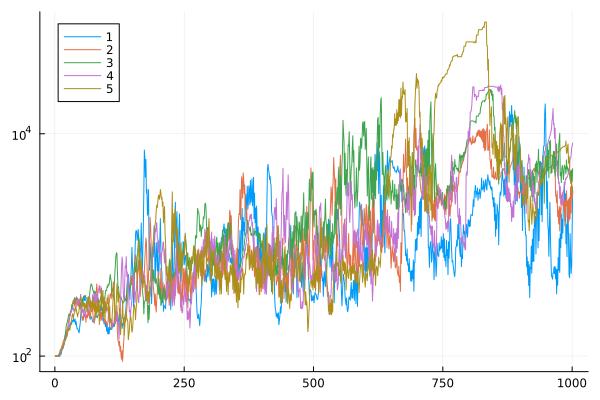

In [6]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

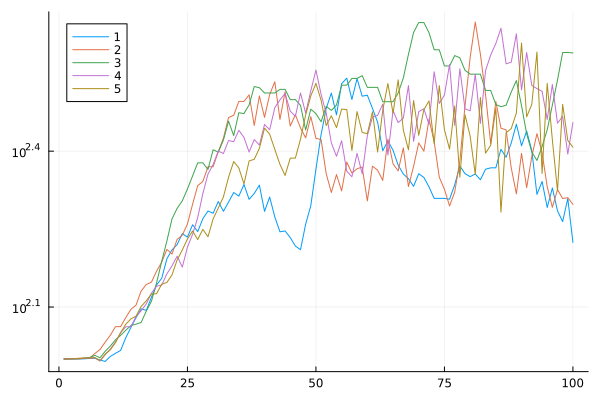

In [7]:
plot(firms[1].stockPriceLog[1:100].*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100].*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[1:100].*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

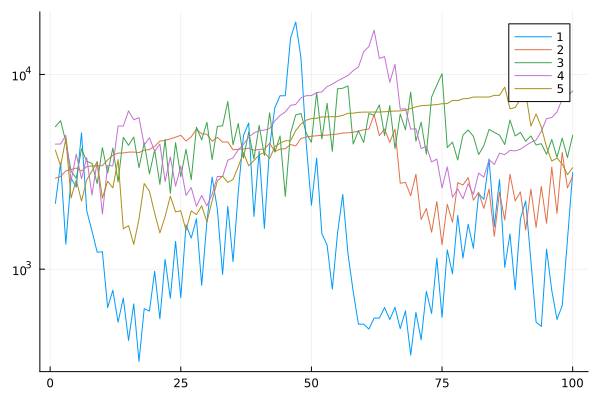

In [8]:
plot(firms[1].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(5), yscale=:log10)

In [9]:
agents

100-element Vector{Agent}:
 Agent("chart", 50.0151141818958, [0.028360240273711337, 0.8009644055484852, 0.026693951802684773, 0.2403598566314008, 0.1409915259785156, 0.18357332812589988, 0.14763326284109832, 0.049253941486889885, 0.06680629684686257, 0.5597627709606355], [0.8887696643168208, 23.97232444820678, 1.297184693236031, 19.768748438693013, 4.676920525612045, 13.77163516153917, 27.804171090989314, 1.0774883025534194, 6.761647008883729, 65.3319086455003], [100.0, 100.69651258481342, 101.44555792204149, 102.18397509467965, 102.9305633805651, 103.67405871150967, 103.72448776764612, 103.85676550089504, 103.9007711337001, 103.9457711337001  …  172.7020192971646, 181.35135533823345, 179.10471066371912, 184.8692743457079, 177.6949729710958, 192.53396964832388, 187.02467052628765, 206.09960346988365, 203.8639299820196, 215.3209121614264], [0.5438935993107654, 2.0, -0.357038993315913, 0.17953077264564798, -1.3074143126071165, 0.02536217683386499, 1.4595603564435164, 0.36124312492633315,

In [10]:
firms

10-element Vector{Firm}:
 Firm(31.33858020027673, 100.0, [1.0, 1.0003897739805008, 1.0006242350087042, 1.0006980704143102, 1.000793135464935, 1.0024337201162807, 1.0031453262918828, 0.9953642324497565, 0.9891834035097492, 1.0114316652017072  …  22.407345788785506, 11.070534356437234, 5.347956646390213, 5.080786644735653, 12.657432872331174, 7.77018934658957, 5.52036830888323, 6.497864424852473, 14.10402106800369, 31.33858020027673], [100.0], 3133.858020027673, 15.618418374065742, Any[], Any[(14.10402106800369, 7.010430308096808, 66), (14.10402106800369, 4.157674025940215, 27), (14.10402106800369, 0.685987202127738, 26), (14.10402106800369, 0.4142095018072981, 41), (14.10402106800369, 0.2815777048067829, 29), (14.10402106800369, 0.1723124473949963, 98)])
 Firm(29.929325550729047, 100.0, [1.0, 1.0005313293526967, 1.0014790418664512, 1.0036977836298109, 1.0039037578107313, 1.0044143179198997, 1.024696608230923, 1.0430588477829734, 1.0776388624131332, 1.1108109643858484  …  15.889531142581

In [11]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

79914.62725980624

In [12]:
for firm in firms[1:10]
    println(firm.hiddenCorporateValue)
end

15.618418374065742
83.2935432444839
117.89969614759391
82.57318673490366
81.17315357371419
215.06602704466684
456.67151608746013
96.43882304185254
162.88352457048072
97.10288252351758


In [13]:
for firm in firms[1:10]
    println(firm.marketCapitalization)
end

3133.858020027673
2992.9325550729045
4859.470425452574
8224.646459582887
3317.164271507153
7501.980435901987
18833.27006117564


2187.6184322024637
10121.271987853459
11671.356516508074


In [14]:
for agent in agents[1:10]
    println(agent.fundamentals)
end

[21.394365959182682, 69.25717287015634, 132.1188840542372, 87.42006231129852, 78.41870984469183, 177.087061047706, 371.5839616565566, 103.24515538764972, 114.74981612341429, 88.4742364511912]
[17.88074077685497, 66.2855751997514, 116.91609601267147, 101.36516440821427, 79.79609632948733, 190.77295496018465, 351.49775811109436, 101.05509397542421, 134.92638130528104, 82.45898596369275]
[18.627139723059564, 81.9584026518584, 129.70280689804272, 93.31671160349337, 86.69906690048319, 184.49923335969083, 373.0860439437826, 100.71429768457627, 124.31342295114386, 84.69354978147106]
[17.53229129115348, 72.18573932807386, 115.41929102334959, 85.75867530602127, 98.14966548035085, 188.93304086630238, 395.0880528486916, 100.72584560154078, 142.52067774239856, 88.34412191056428]
[16.802767445768147, 72.72213830552603, 114.57551788339907, 89.93997344333495, 83.56770704414308, 212.44542802111806, 364.4570836066898, 100.69068025348356, 116.80106150063072, 86.37168032687777]
[16.923246523119126, 64.74

In [15]:
for agent in agents[1:10]
    println(agent.params)
end

[0.5438935993107654, 2.0, -0.357038993315913, 0.17953077264564798, -1.3074143126071165, 0.02536217683386499, 1.4595603564435164, 0.36124312492633315, -0.19156895977772892, -0.1390803580574686, 0.854361702078039, 73.0]
[0.7459842663203363, 36.0]
[0.7896633551582645, 3.0, -1.4430152571873702, 0.062427486992017264, -0.15206009348678418, 1.3647313045130678, 0.16791655916906972, 0.1693747130600901, -0.08109028647042811, -0.018443902424559004, 0.19355929708914218, 52.0]
[0.7311598579256261, 21.0]
[0.893536917406349, 12.0]
[0.9613198844889945, 4.0, -1.2648448597073438, -0.13668459819126044, -0.33140550225412524, 1.4870008822817269, 0.24593407787100244, -0.00248001224632114

, -0.12131533447269817, 0.14161336419125214, 0.16531829839803183, 15.0]
[0.7426552716534955, 13.0]
[0.9997653595408509, 22.0]
[0.5093436220698949, 2.0, -0.1887674321004793, -0.05926305595425273, -1.3003022120414085, 0.04225042965698086, 1.5060822704391597, -0.008503194638624707, -0.42104146983506197, -0.009133782247670535, 0.6306542208017405, 92.0]
[0.5130296132143611, 4.0, -1.3047794968938173, -0.026642515685866956, -0.44250558149989455, 1.4005881231120676, 0.3733394709675114, 0.017425755688130665, -0.1806072230927517, 0.13730595585519445, 0.22077187757576114, 11.0]


In [16]:
for agent in agents[1:10]
    println(agent.sharesQuantity)
end

[0.028360240273711337, 0.8009644055484852, 0.026693951802684773, 0.2403598566314008, 0.1409915259785156, 0.18357332812589988, 0.14763326284109832, 0.049253941486889885, 0.06680629684686257, 0.5597627709606355]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0731640699255867, 0.0, 0.22177206392068888, 0.4154896058822406, 0.46872488703908555, 0.6689478780454073, 0.454011559431936, 0.0, 0.04817763056432918, 1.3956754682088477]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.1910831516282174, 0.8767632263739047, 0.0, 1.5401957347099198, 0.0, 0.0, 7.0437490520616794, 0.0, 0.0]
[0.0, 8.935329567086825, 0.0, 6.011226074729727, 30.477352203526166, 0.0, 17.386838033333273, 9.050373490396764, 5.756088568370735, 0.0]
[0.0015379658109827383, 0.003947788184904749, 0.0017964333906784428, 0.00013817694839033604, 0.004132838823100269, 0.003701080353545148, 0.0034968557105154296, 0.0, 0.0001266333715650974, 9.792734897224333e-5]
[0.13828695475708971, 0.18506691340120732, 0.0, 0.14463928470240012, 0.1996241777201407, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 3.5561641939700173, 0.36671862873956973, 0.0, 0.6239981521806045, 0.0, 0.0, 2.5113053940783665, 0.0, 0.0]


In [17]:
for firm in firms[1:10]
    println(firm.stockQuantityLog)
end

[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
